In [3]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
#from scipy import stats

from shallow_model import Model

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
class z24Dataset(Dataset):
    def __init__(self, filename = '40C07',window_size=100, normalize=True):
        self.window_size = window_size
        self.slices_per_file = 65536 // self.window_size
        self.normalize = normalize
        self.filename = filename
            
        self.env_mean = np.load('../tools/env_mean.npy')
        self.env_std = np.load('../tools/env_std.npy')
        self.vibration_mean = np.load('../tools/vibration_mean.npy')
        self.vibration_std = np.load('../tools/vibration_std.npy')

    def __len__(self):
        return self.slices_per_file

    def __getitem__(self, index):
        index_to_read = index // self.slices_per_file
        index_in_dataframe = (index - index_to_read*self.slices_per_file) * self.window_size
        
        file_path_vib = '../data/z24_clean/'+self.filename+'_vibrations.npy'
        file_path_env = '../data/z24_clean/'+self.filename+'_env.npy'

        memmap_vib = np.memmap(file_path_vib, dtype=np.float64, mode='r', shape=(65536, 7))
        memmap_env = np.memmap(file_path_env, dtype=np.float64, mode='r', shape=(53,))

        X_environmental = np.array(memmap_env[:])
        X_vibration_window = np.array(memmap_vib[index_in_dataframe:index_in_dataframe+self.window_size,:])

        if self.normalize:
            X_vibration_window = (X_vibration_window - self.vibration_mean) / self.vibration_std
            X_environmental = (X_environmental - self.env_mean) / self.env_std
        
        X_vib_and_env = np.append(X_vibration_window.flatten(),X_environmental)
       
        return X_vib_and_env, X_vibration_window.flatten()


In [3]:
file_index = np.loadtxt('../tools/test_set_index.txt',dtype=str)
w_size = 200
testset_errors = np.load('../tools/testset_error_distribution_shallow.npy')

In [4]:
classification_list = []
allt = []
for damage_file in file_index:
    dataset = z24Dataset(filename = damage_file, window_size=w_size, normalize=True)
    dataloader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=4)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torch.load(f='../results/trained_shallow_relu200.pt', map_location='cpu')
    loss_criterion = torch.nn.MSELoss(reduce=False)
    
    all_window_loss = []
    for X, Y in dataloader:
        X_tensor = X.float().to(device)
        Y_tensor = Y.float().to(device)
    
        batch_size, output_size = Y.shape
        N = 100
        N_predictions = torch.zeros([N, batch_size, output_size])
    
        for i in range(N):
            N_predictions[i,:,:] = model(X_tensor)
    
        prediction_mean = torch.mean(N_predictions, dim=0)
        prediction_std = torch.std(N_predictions, dim=0)
    
        loss_full = loss_criterion(prediction_mean, Y_tensor)
    
        lower_y = prediction_mean - 2*prediction_std
        upper_y = prediction_mean + 2*prediction_std
        within_lower = Y_tensor > lower_y
        within_upper = Y_tensor < upper_y
        within_range = within_lower & within_upper
    
        loss_full[within_range] = 0
    
        for j in range(batch_size):
            window_loss = torch.sum(loss_full[j,:]) / torch.numel(loss_full[j,:])
            all_window_loss.append(window_loss.item())
    allt.append(all_window_loss)
    losses_no_outliers = np.sort(all_window_loss)[:int(0.95*len(all_window_loss))]
    max_error = np.max(losses_no_outliers)
    
    classification = np.max(testset_errors) < max_error
    
    classification_list.append(classification)
    
    print('classified as {}'.format(classification))
    print(max_error)

classified as False
0.000574418343603611
classified as True
0.8524396419525146
classified as True
0.6484630703926086
classified as False
0.005850144661962986
classified as True
1.6148474216461182
classified as True
1.2068678140640259
classified as False
0.08440005034208298
classified as True
9.483445167541504
classified as False
0.1519424170255661
classified as False
0.07218927890062332
classified as False
0.002166664693504572
classified as True
2.702432870864868
classified as True
1.6181654930114746
classified as True
1.417055606842041


Process Process-59:
Process Process-60:
Process Process-58:
Process Process-57:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dsteinar/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dsteinar/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dsteinar/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/dsteinar/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dsteinar/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dsteinar/miniconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/dsteinar/miniconda3/lib/python3.6/multi

KeyboardInterrupt: 

In [ ]:
n_correct = np.sum(classification_list)
print('Number of cases: {}'.format(len(classification_list)))
print('Number of correct classifications: {}'.format(int(n_correct)))
print('Ratio {}'.format(n_correct/len(classification_list)))

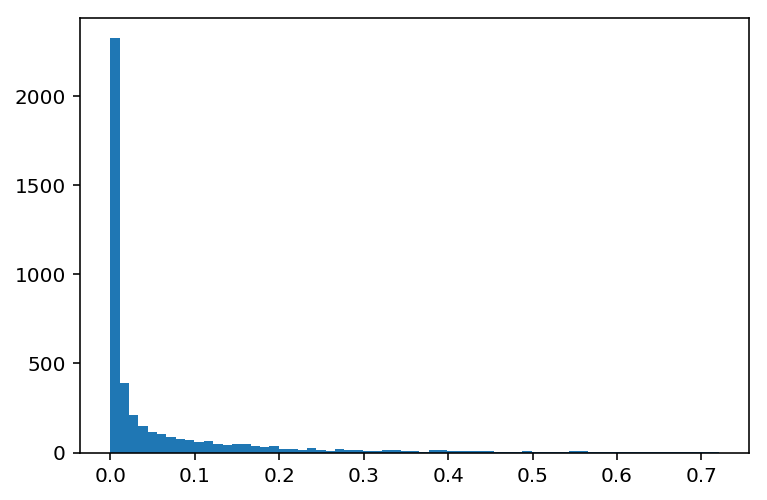

In [5]:
test = np.array(allt).flatten()
nooutlier= np.sort(test)[:int(0.95*len(test))]
plt.hist(nooutlier,bins=65)
plt.show()

In [6]:
np.sum(nooutlier > np.max(testset_errors))

133

In [7]:
len(nooutlier)

4349

In [8]:
len(test)

4578

In [9]:
153/4905

0.031192660550458717

In [10]:
file_index

array(['01G03', '01D09', '01G10', '01F05', '01C19', '01E10', '01E06',
       '01D14', '01D06', '01D23', '01G05', '01G17', '01F19', '01C15',
       '01G07'], dtype='<U5')

In [4]:
classification_list = []
allt = []
damage_file = '01D09'
dataset = z24Dataset(filename = damage_file, window_size=w_size, normalize=True)
dataloader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(f='../results/trained_shallow_relu200.pt', map_location='cpu')
loss_criterion = torch.nn.MSELoss(reduce=False)

all_window_loss = []
for X, Y in dataloader:
    X_tensor = X.float().to(device)
    Y_tensor = Y.float().to(device)

    batch_size, output_size = Y.shape
    N = 100
    N_predictions = torch.zeros([N, batch_size, output_size])

    for i in range(N):
        N_predictions[i,:,:] = model(X_tensor)

    prediction_mean = torch.mean(N_predictions, dim=0)
    prediction_std = torch.std(N_predictions, dim=0)

    loss_full = loss_criterion(prediction_mean, Y_tensor)

    lower_y = prediction_mean - 2*prediction_std
    upper_y = prediction_mean + 2*prediction_std
    within_lower = Y_tensor > lower_y
    within_upper = Y_tensor < upper_y
    within_range = within_lower & within_upper

    loss_full[within_range] = 0

    for j in range(batch_size):
        window_loss = torch.sum(loss_full[j,:]) / torch.numel(loss_full[j,:])
        all_window_loss.append(window_loss.item())
losses_no_outliers = np.sort(all_window_loss)[:int(0.95*len(all_window_loss))]

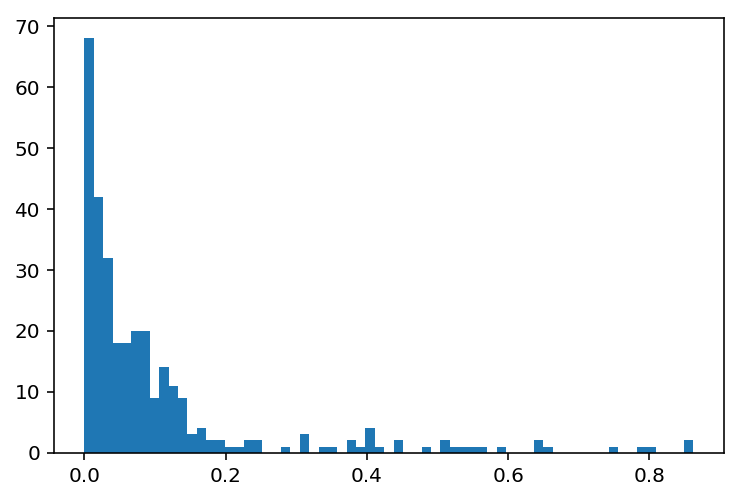

In [5]:
plt.hist(losses_no_outliers,bins=65,label='t')
plt.show()

In [6]:
plt.hist(nooutlier,bins=65)
plt.show()

NameError: name 'nooutlier' is not defined

In [17]:
t = np.load('../tools/total_testset_window_errors.npy')

In [18]:
t.shape

(741, 327)

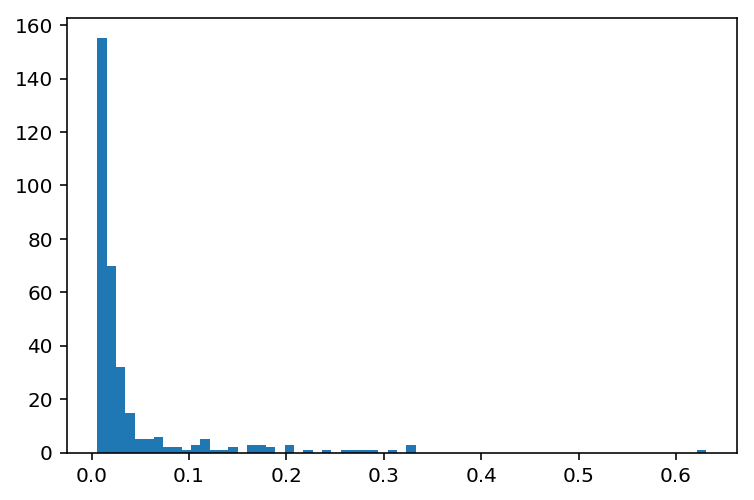

In [19]:
plt.hist(t[0,:], bins=65)
plt.show()

In [20]:
#t[t > 8.727523803710938] = 8.727523803710938 0.3368719816207886
#t[t > 0.3368719816207886] = 0.3368719816207886

In [21]:
means = np.mean(t, axis=1)

In [22]:
rejectmeans = np.sort(means)[704]
rejectmeans

0.7925939997561121

In [23]:
sums = np.sum(t, axis=1)

In [24]:
rejectsums = np.sort(sums)[704]

In [25]:
rejectsums

259.17823792024865

In [26]:
squaredsums = np.sum(t**2, axis=1)

In [27]:
rejectsquaredsums = np.sort(squaredsums)[704]

In [28]:
rejectsquaredsums

6392.616521851132

In [29]:
maxx = np.max(t, axis=1)
rejectmax = np.sort(maxx)[704]
rejectmax

49.096405029296875

In [30]:
tsorted = np.sort(t.flatten())
tsorted[int(len(t.flatten())*0.95)]

0.3368719816207886

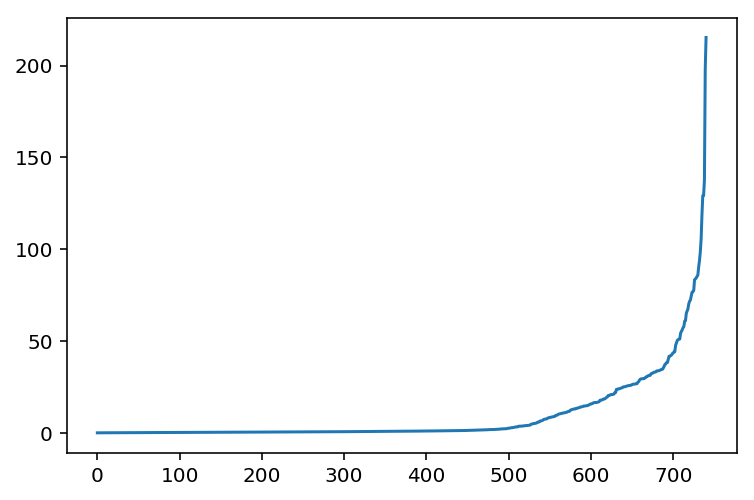

In [31]:
plt.plot(np.sort(maxx))

In [2]:
fig, ax = plt.subplots(7, sharex=True, squeeze=True,figsize=(30,20))

memmap_vib = np.memmap('../data/z24_damage/4/41D09_vibrations.npy', dtype=np.float64, mode='r', shape=(65536, 7))
data = np.array(memmap_vib)

vibration_mean = np.load('../tools/vibration_mean.npy')
vibration_std = np.load('../tools/vibration_std.npy')
data = (data - vibration_mean) / vibration_std

for i in range(7):
    ax = plt.subplot(7,1,i+1)
    plt.plot(data[:,i], label='True', linewidth=0.1)

plt.subplots_adjust(wspace=0.5, hspace=0.05)
#plt.savefig('damagecase_7_predictions40C07.pdf')

NameError: name 'plt' is not defined

In [16]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from shallow_model import Model

import numpy as np

class z24Dataset_sequence(Dataset):
    def __init__(self, filename = '40C07',window_size=100, normalize=True):
        self.window_size = window_size
        self.slices_per_file = 65536 // self.window_size
        self.normalize = normalize
        self.filename = filename
            
        self.env_mean = np.load('../tools/env_mean.npy')
        self.env_std = np.load('../tools/env_std.npy')
        self.vibration_mean = np.load('../tools/vibration_mean.npy')
        self.vibration_std = np.load('../tools/vibration_std.npy')

    def __len__(self):
        return self.slices_per_file

    def __getitem__(self, index):
        index_to_read = index // self.slices_per_file
        index_in_dataframe = (index - index_to_read*self.slices_per_file) * self.window_size
        
        file_path_vib = '../data/z24_clean/'+self.filename+'_vibrations.npy'
        file_path_env = '../data/z24_clean/'+self.filename+'_env.npy'

        memmap_vib = np.memmap(file_path_vib, dtype=np.float64, mode='r', shape=(65536, 7))
        memmap_env = np.memmap(file_path_env, dtype=np.float64, mode='r', shape=(53,))

        X_environmental = np.array(memmap_env[:])
        X_vibration_window = np.array(memmap_vib[index_in_dataframe:index_in_dataframe+self.window_size,:])

        if self.normalize:
            X_vibration_window = (X_vibration_window - self.vibration_mean) / self.vibration_std
            X_environmental = (X_environmental - self.env_mean) / self.env_std
        
        X_vib_and_env = np.append(X_vibration_window.flatten(),X_environmental)
       
        return X_vib_and_env, X_vibration_window.flatten()


filename = '01D15'

batch_size = 100
window_size = 200
dataset = z24Dataset_sequence(filename=filename, window_size=window_size, normalize=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(f='../results/trained_shallow_relu200.pt', map_location='cpu')

loss_criterion = torch.nn.MSELoss(reduce=False)

sequence_window_loss = []

for X, Y in dataloader:
    X_tensor = X.float().to(device)
    Y_tensor = Y.float().to(device)

    batch_size, output_size = Y.shape
    N = 100
    N_predictions = torch.zeros([N, batch_size, output_size])

    for i in range(N):
        N_predictions[i,:,:] = model(X_tensor)

    prediction_mean = torch.mean(N_predictions, dim=0)
    prediction_std = torch.std(N_predictions, dim=0)

    loss_full = loss_criterion(prediction_mean, Y_tensor)

    lower_y = prediction_mean - 2*prediction_std
    upper_y = prediction_mean + 2*prediction_std
    within_lower = Y_tensor > lower_y
    within_upper = Y_tensor < upper_y
    within_range = within_lower & within_upper

    loss_full[within_range] = 0

    for j in range(batch_size):
        window_loss = torch.sum(loss_full[j,:]) / torch.numel(loss_full[j,:])
        sequence_window_loss.append(window_loss.item())

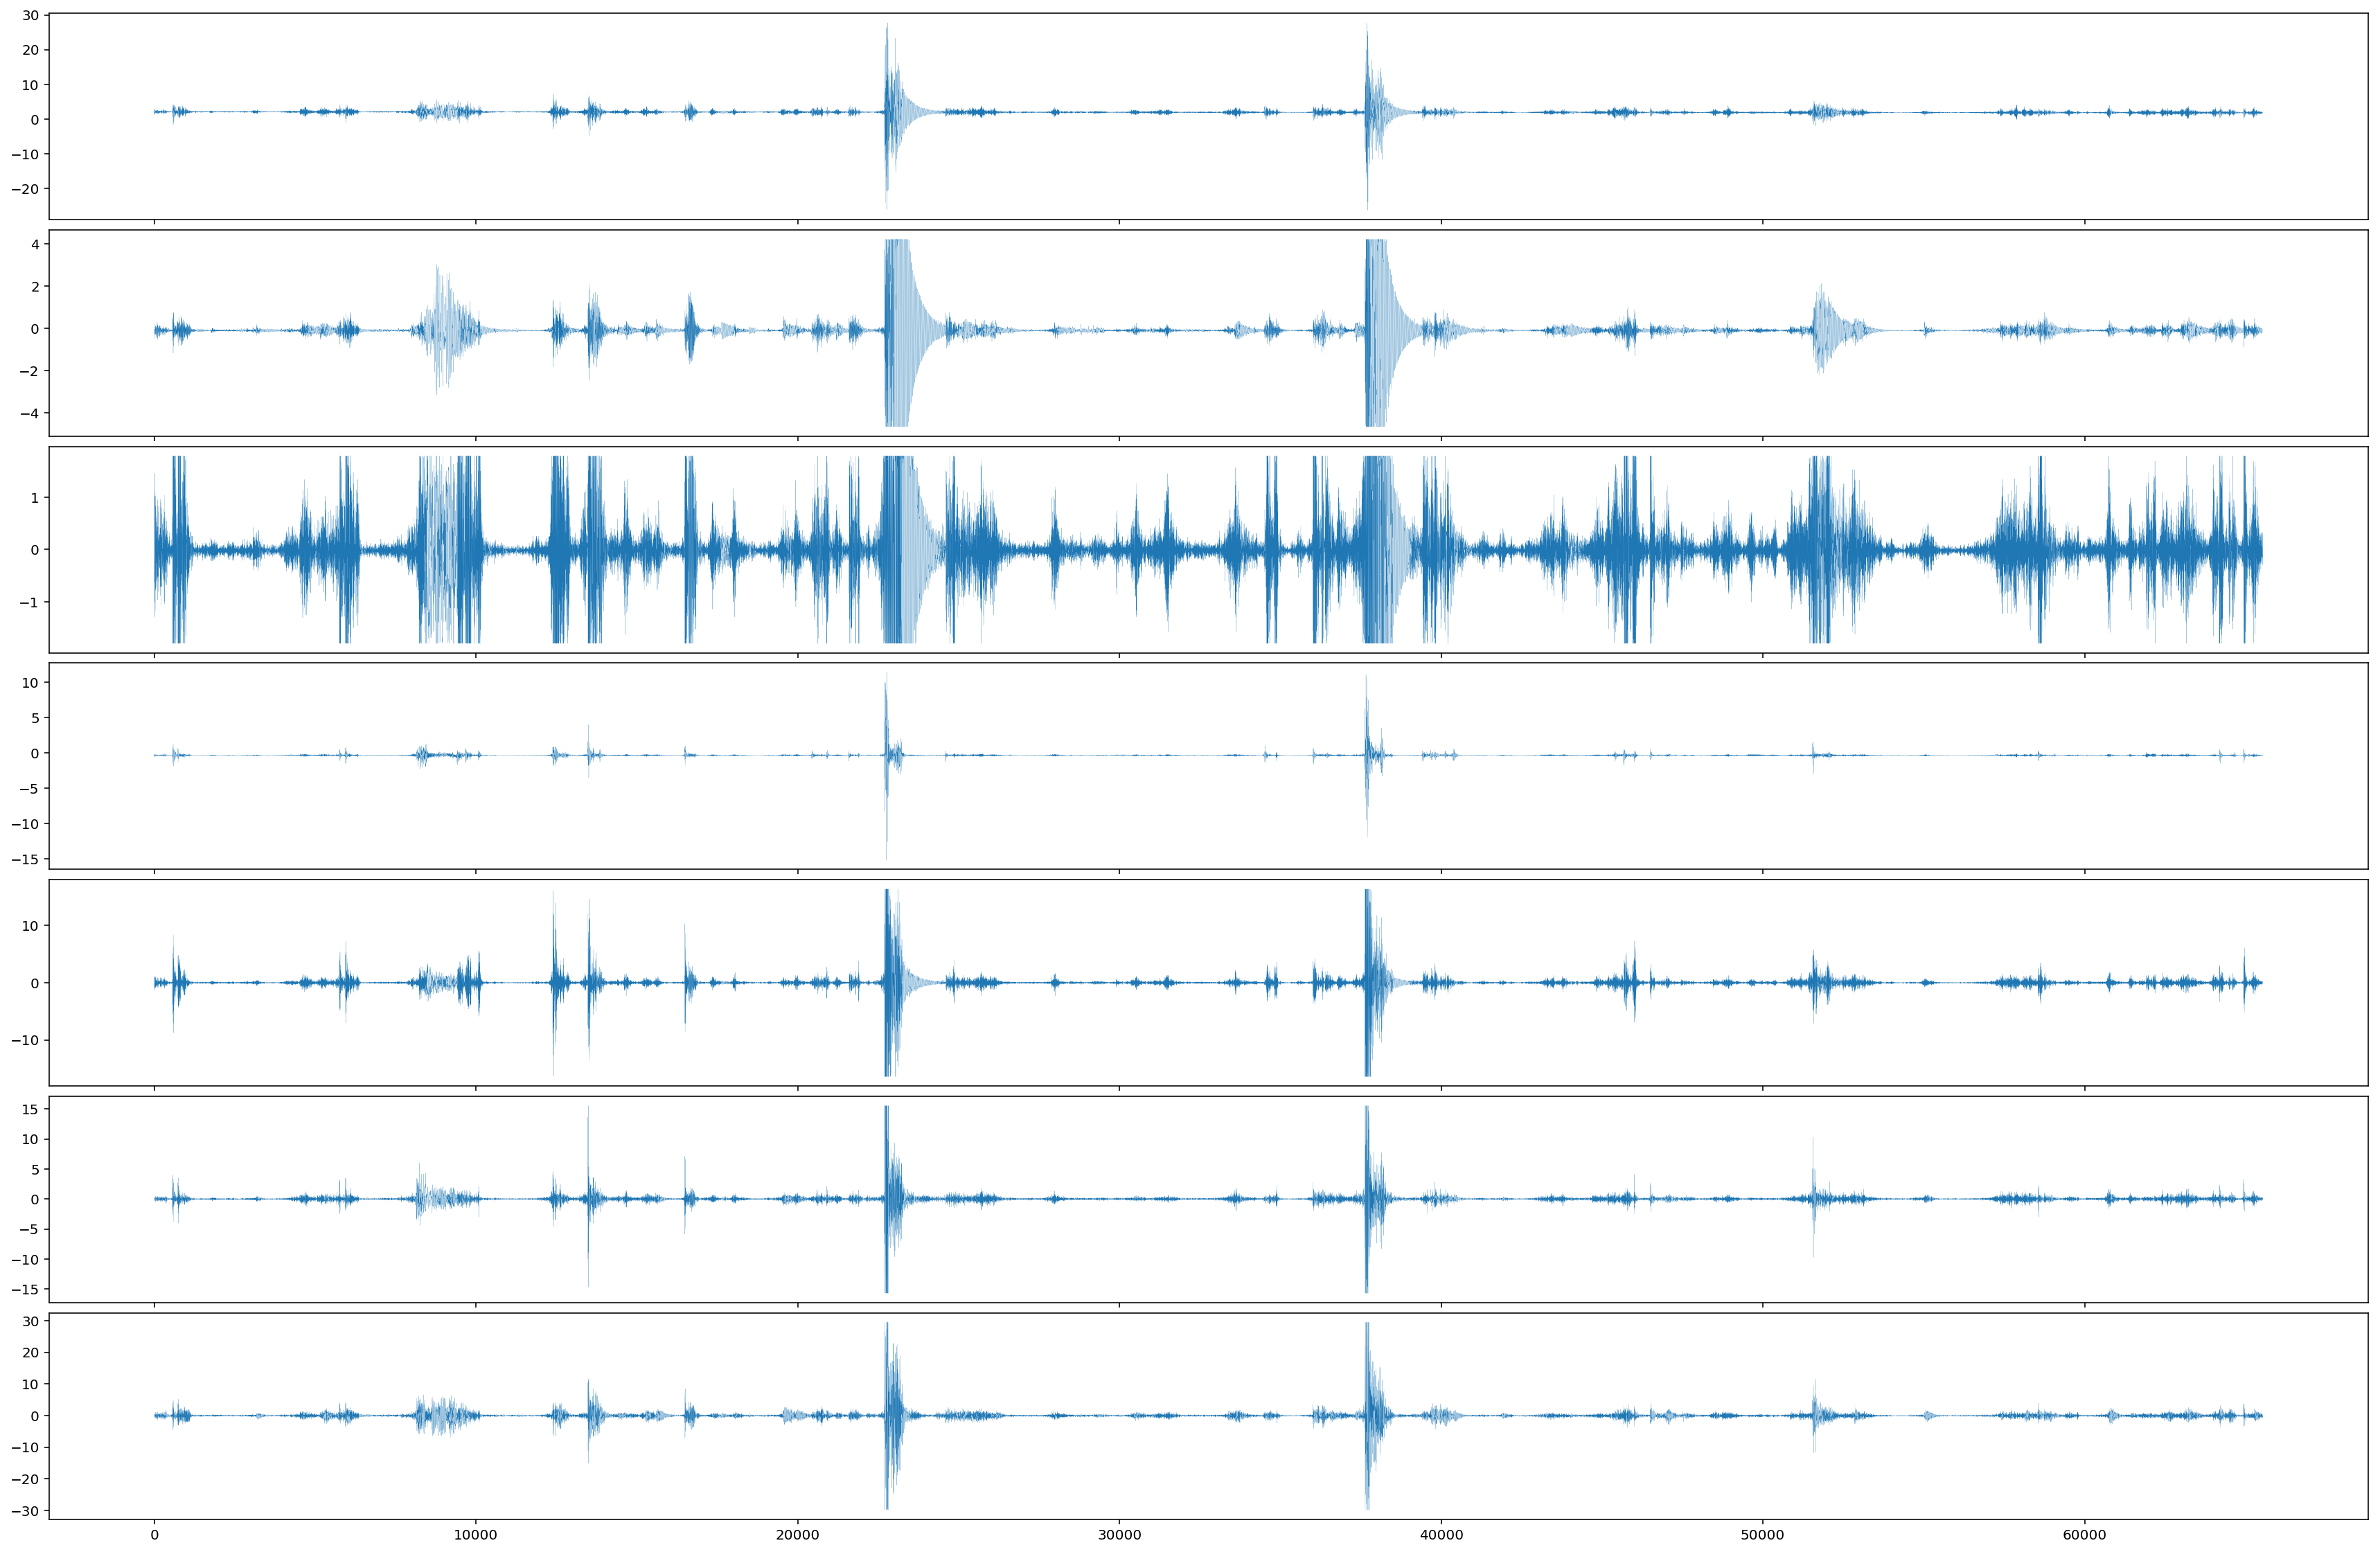

In [5]:
fig, ax = plt.subplots(7, sharex=True, squeeze=True,figsize=(30,20))
filename = '01D15'

memmap_vib = np.memmap('../data/z24_clean/'+filename+'_vibrations.npy', dtype=np.float64, mode='r', shape=(65536, 7))
data = np.array(memmap_vib)

vibration_mean = np.load('../tools/vibration_mean.npy')
vibration_std = np.load('../tools/vibration_std.npy')
data = (data - vibration_mean) / vibration_std

for i in range(7):
    ax = plt.subplot(7,1,i+1)
    plt.plot(data[:,i], label='True', linewidth=0.1)

plt.subplots_adjust(wspace=0.5, hspace=0.05)

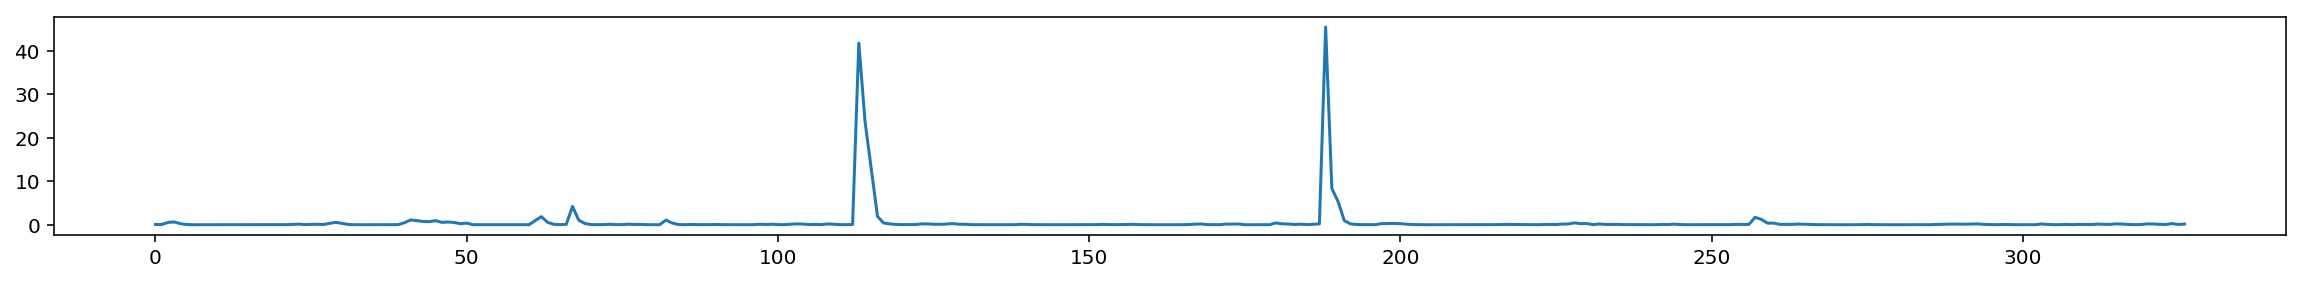

In [18]:
plt.figure(figsize=(20,2))
plt.plot(sequence_window_loss)